<a href="https://colab.research.google.com/github/nicole-malaquias/property_price_analysis/blob/main/LH_CD_nicole_malaquias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Importes

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from wordcloud import WordCloud

from scipy import stats



caminho = '/content/drive/MyDrive/Colab Notebooks/desafio/teste_indicium_precificacao.csv'
df = pd.read_csv(caminho)

caminho_turismo = '/content/drive/MyDrive/Colab Notebooks/desafio/New_York_Tourist_Locations.xlsx'
df_t = pd.read_excel(caminho_turismo)

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Data Wrangling

In [ ]:
def rename_columns(df: pd.DataFrame, mapping: dict) -> None:
    """
    Renomeia as colunas de um DataFrame conforme o mapeamento fornecido.

    Parâmetros:
        df (pd.DataFrame): DataFrame que contém as colunas a serem renomeadas.
        mapping (dict): Um dicionário onde as chaves são os nomes atuais das colunas e os valores são os novos nomes das colunas.

    Retorna:
        None: A função modifica o DataFrame fornecido inplace e não retorna nada.

    """
    df.rename(columns=mapping, inplace=True)

mapping = {
    'id': 'id',
    'nome': 'name',
    'host_id': 'host_id',
    'host_name': 'host_name',
    'bairro_group': 'neighborhood_group',
    'bairro': 'neighborhood',
    'latitude': 'latitude',
    'longitude': 'longitude',
    'room_type': 'room_type',
    'price': 'price',
    'minimo_noites': 'minimum_nights',
    'numero_de_reviews': 'number_of_reviews',
    'ultima_review': 'last_review',
    'reviews_por_mes': 'reviews_per_month',
    'calculado_host_listings_count': 'calculated_host_listings_count',
    'disponibilidade_365': 'availability_365'
}

rename_columns(df, mapping)

In [ ]:

def preprocess_text(value):
    """
    Pré-processa um valor de texto removendo espaços em branco adicionais e envolvendo-o em aspas simples,
    se não for nulo.

    Parâmetros:
        value: O valor de texto a ser pré-processado.

    Retorna:
        str: O valor de texto pré-processado, com espaços em branco removidos e envolto em aspas simples,
             se não for nulo.

    Exemplo:
        >>> preprocess_text("  Hello World  ")
        "'Hello World'"
    """
    return str(value).strip() if pd.notnull(value) else ''

df['name'] = df['name'].apply(preprocess_text)


In [ ]:
def removed_outlier(df):
    """
    Remove outliers da coluna 'price' de um DataFrame.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo a coluna 'price' com os outliers a serem removidos.

    Retorna:
        pd.DataFrame: DataFrame sem os outliers na coluna 'price'.

    Exemplo:
        >>> df = pd.DataFrame({'price': [100, 150, 200, 250, 300, 1000]})
        >>> df_sem_outliers = removed_outlier(df)
        Número de outliers removidos: 1
        >>> print(df_sem_outliers)
           price
        0    100
        1    150
        2    200
        3    250
        4    300
    """
    Q1 = df['price'].quantile(0.25)
    Q3 = df['price'].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df_sem_outliers = df[(df['price'] >= limite_inferior) & (df['price'] <= limite_superior)]
    print("Número de outliers removidos:", len(df) - len(df_sem_outliers))
    return df_sem_outliers

df = removed_outlier(df)


Número de outliers removidos: 2972


In [ ]:
def preencher_reviews_per_month(dataset):
    """
    Preenche os valores faltantes na coluna 'reviews_per_month' com 0 se 'last_review' ou 'number_of_reviews' forem nulos.

    Parâmetros:
        dataset (pd.DataFrame): DataFrame contendo as colunas 'last_review', 'number_of_reviews' e 'reviews_per_month'.

    Retorna:
        pd.DataFrame: DataFrame com os valores faltantes na coluna 'reviews_per_month' preenchidos com 0.

    Exemplo:
        >>> df = pd.DataFrame({'last_review': [None, '2022-01-01', '2022-02-01', None],
        ...                    'number_of_reviews': [10, None, 5, None],
        ...                    'reviews_per_month': [0, 0, 0, 0]})
        >>> df = preencher_reviews_per_month(df)
        >>> print(df)
           last_review  number_of_reviews  reviews_per_month
        0         None               10.0                0.0
        1  2022-01-01                NaN                0.0
        2  2022-02-01                5.0                0.0
        3         None                NaN                0.0
    """
    condicao_vazios = dataset['last_review'].isnull() | dataset['number_of_reviews'].isnull()
    dataset.loc[condicao_vazios, 'reviews_per_month'] = 0
    return dataset

# Exemplo de uso
df = preencher_reviews_per_month(df)


In [ ]:
def create_dummy_variables(df):
    """
    Cria variáveis dummy para as colunas 'room_type' e 'neighborhood_group' de um DataFrame.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo as colunas 'room_type' e 'neighborhood_group' para criar variáveis dummy.

    Retorna:
        pd.DataFrame: DataFrame com variáveis dummy adicionadas para 'room_type' e 'neighborhood_group'.

    Exemplo:
        >>> df = pd.DataFrame({'room_type': ['Entire home', 'Private room', 'Shared room'],
        ...                    'neighborhood_group': ['Bronx', 'Manhattan', 'Queens']})
        >>> df = create_dummy_variables(df)
        >>> print(df.columns)
        Index(['room_type', 'neighborhood_group', 'Entire home', 'Private room', 'Shared room', 'Group A', 'Group B', 'Group C'], dtype='object')
    """
    dummies_room_type = pd.get_dummies(df['room_type'])
    df = pd.concat([df, dummies_room_type], axis=1)

    dummies_neighborhood_group = pd.get_dummies(df['neighborhood_group'])
    df = pd.concat([df, dummies_neighborhood_group], axis=1)

    return df


df = create_dummy_variables(df)



In [ ]:
def add_tourist_spot_count(dataset, tourist_spot_data):
    """
    Cria o campo tourist_spot_count no dataset de locação.

    Esta função calcula a quantidade de pontos turísticos em cada bairro de Nova York
    e adiciona essa informação como uma nova coluna chamada "tourist_spot_count" ao
    dataset de locação.

    Parâmetros:
    - dataset (DataFrame): O conjunto de dados de locação contendo informações sobre
                           os imóveis em Nova York.
    - tourist_spot_data (DataFrame): O conjunto de dados contendo informações sobre
                                     os pontos turísticos em Nova York, com pelo menos
                                     duas colunas: "neighborhood" (bairro) e
                                     "tourist_spot_count" (quantidade de pontos turísticos).

    Retorna:
    - DataFrame: O dataset de locação com o campo "tourist_spot_count" adicionado.

    Exemplo de Uso:
    >>> dataset = add_tourist_spot_count(dataset, tourist_spot_data)
    """
    borough_count = {'Bronx': 0, 'Brooklyn': 0, 'Manhattan': 0, 'Queens': 0, 'Staten Island': 0}

    boroughs_of_nyc = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

    for address in tourist_spot_data['Address']:
        address_lower = address.lower()
        for borough in boroughs_of_nyc:
            if borough.lower() in address_lower:
                borough_count[borough] += 1

    dataset['tourist_spot_count'] = 0

    for index, row in dataset.iterrows():
        neighborhood_group = row['neighborhood']
        if neighborhood_group in borough_count:
            dataset.at[index, 'tourist_spot_count'] = borough_count[neighborhood_group]
        else:
            # Se o bairro não estiver presente nos dados de pontos turísticos, atribua 0
            dataset.at[index, 'tourist_spot_count'] = 0

    return dataset

df = add_tourist_spot_count(df, df_t)

In [ ]:
def replace_zero_prices_with_mean(df):
    """
    Substitui os preços zero no DataFrame pela média dos preços para o mesmo tipo de quarto.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo a coluna 'price' com preços, e a coluna 'room_type' com os tipos de quarto.

    Retorna:
        pd.DataFrame: DataFrame com preços zero substituídos pela média dos preços para o mesmo tipo de quarto.

    Exemplo:
        >>> df = pd.DataFrame({'room_type': ['Entire home', 'Private room', 'Shared room'],
        ...                    'price': [100, 0, 0]})
        >>> df = replace_zero_prices_with_mean(df)
        >>> print(df['price'])
        0    100.0
        1    100.0
        2     50.0
        Name: price, dtype: float64
    """
    acomodacoes_zero = df[df['price'] == 0]

    for index, row in acomodacoes_zero.iterrows():
        tipo_quarto = row['room_type']
        media_tipo_quarto = df[df['room_type'] == tipo_quarto]['price'].mean()
        df.at[index, 'price'] = media_tipo_quarto

    return df


df = replace_zero_prices_with_mean(df)



# Pergunta 1

Faça uma análise exploratória dos dados (EDA), demonstrando as principais
características entre as variáveis e apresentando algumas hipóteses de
negócio relacionadas.



### Analisando a distribuição da variável **price**

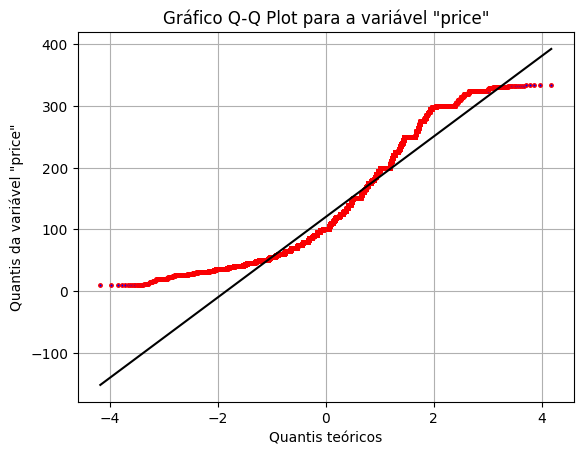

In [ ]:
price = df['price']

# Criar o gráfico Q-Q plot
fig, ax = plt.subplots()
stats.probplot(price, dist="norm", plot=ax)

ax.get_lines()[1].set_color('black')
ax.get_lines()[0].set_markerfacecolor('blue')
ax.get_lines()[0].set_markeredgecolor('red')
ax.get_lines()[0].set_markersize(2.5)

plt.title('Gráfico Q-Q Plot para a variável "price"')
plt.xlabel('Quantis teóricos')
plt.ylabel('Quantis da variável "price"')
plt.grid(True)
plt.show()


 Teste de Shapiro Wilk

In [ ]:
price = df['price']

shapiro_stat, shapiro_p_valor = stats.shapiro(price)

if shapiro_p_valor > 0.5 :
    print("Com 95% de segurança os dados são similares a um distribuição normal")

else:
    print("Com 95% de segurança os dados não são similares a um distribuição normal")

Com 95% de segurança os dados não são similares a um distribuição normal


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Com base na análise para determinar se a variável alvo segue uma forma linear, concluiu-se, através do gráfico Q-Q e do teste de Shapiro-Wilk ,pequenos de dados que a variável não é linear.



### Analisando destribuição do dataset

In [ ]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room,Bronx,Brooklyn,Manhattan,Queens,Staten Island,tourist_spot_count
count,4.592200e+04,4.592200e+04,45922.00000,45922.000000,45922.000000,45922.00000,45922.000000,45922.000000,45922.000000,45922.000000,45922.000000,45922.000000,45922.000000,45922.000000,45922.000000,45922.000000,45922.000000,45922.000000,45922.0
mean,1.889894e+07,6.632837e+07,40.72849,-73.950733,119.991396,6.93820,23.942990,1.107758,6.639715,109.373133,0.496255,0.478964,0.024781,0.023300,0.422760,0.424764,0.121227,0.007948,0.0
std,1.091899e+07,7.755800e+07,0.05533,0.046471,68.129083,19.85802,45.315659,1.612669,31.008486,130.275350,0.499991,0.499563,0.155459,0.150857,0.494003,0.494312,0.326395,0.088799,0.0
min,2.595000e+03,2.438000e+03,40.49979,-74.244420,10.000000,1.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,9.436504e+06,7.727013e+06,40.68924,-73.981928,65.000000,1.00000,1.000000,0.050000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.952614e+07,3.028375e+07,40.72177,-73.954365,100.000000,2.00000,5.000000,0.380000,1.000000,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,2.891267e+07,1.055072e+08,40.76339,-73.934313,159.000000,5.00000,24.000000,1.620000,2.000000,217.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0
max,3.648724e+07,2.743213e+08,40.91306,-73.712990,334.000000,1250.00000,629.000000,58.500000,327.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0




A análise descritiva revela que, apesar do preço médio das acomodações ser de 119 dólares, existe uma variação significativa de 63 dólares. Isso reflete uma considerável variabilidade nos preços. Normalmente, um imóvel encontra-se nas proximidades de 74 a 108 pontos turísticos.

### Analisando a distribuição dos tipos de imóveis alugados


In [ ]:
contagem_por_tipo = df['room_type'].value_counts()
contagem_por_tipo

Entire home/apt    22789
Private room       21995
Shared room         1138
Name: room_type, dtype: int64

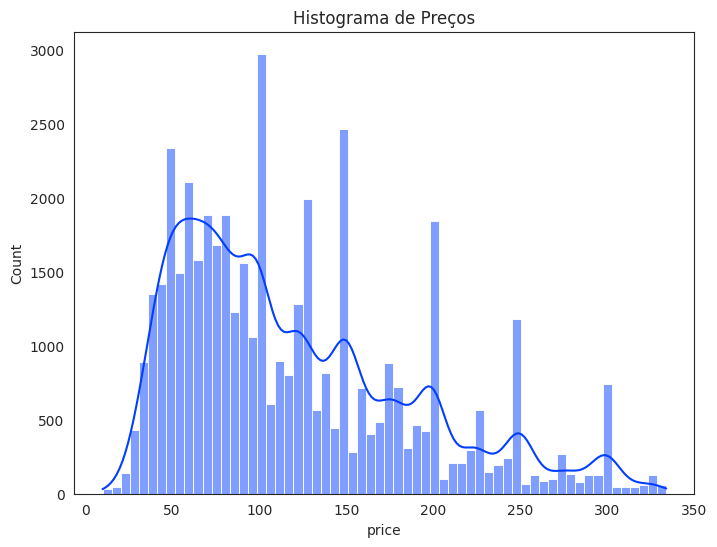

In [ ]:
sns.set_style("white")
sns.set_palette("bright")

plt.figure(figsize=(8, 6))

sns.histplot(data=df, x='price', kde=True)
plt.title('Histograma de Preços')

plt.show()

Como a maior parte dos tipos de locação são "Entire home/apt" e "Private room", é esperado que os valores sejam maiores. No entanto, essas acomodações com preços elevados não são tão frequentes.

### Como os preços variam de acordo com a localização? Qual o bairro com a locação mais cara entre os três tipos de bairro?



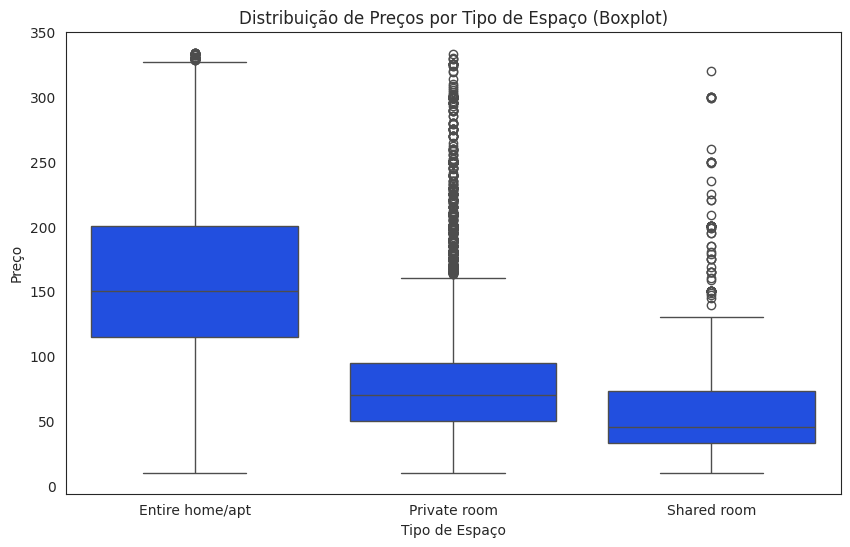

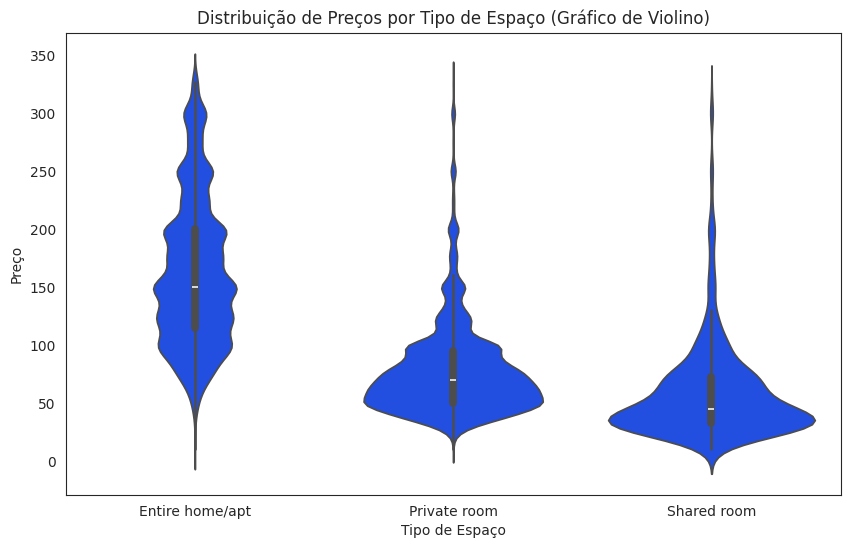

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='room_type', y='price')
plt.title('Distribuição de Preços por Tipo de Espaço (Boxplot)')
plt.xlabel('Tipo de Espaço')
plt.ylabel('Preço')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='room_type', y='price')
plt.title('Distribuição de Preços por Tipo de Espaço (Gráfico de Violino)')
plt.xlabel('Tipo de Espaço')
plt.ylabel('Preço')
plt.show()


Podemos observar que a distribuição de valor nas acomodações de 'casa/apartamento inteiro' é mais orgânica e equilibrada entre os quartis.
Por outro lado, as locações de 'quartos privados' estão concentradas principalmente no primeiro quartil, sendo geralmente mais baratas do que as opções mais em conta de 'casa/apartamento inteiro'.
As acomodações do tipo 'quarto compartilhado' são mais baratas do que as opções mais econômicas de 'quartos privados', mas possuem observações com preços mais altos, semelhantes a outras acomodações. Isso pode ser explicado pela localização, pois mesmo sendo acomodações simples, se estiverem bem localizadas, podem ter valores mais altos.

In [ ]:
tipos_de_acomodacao = ['Entire home/apt', 'Private room', 'Shared room']
df_filtrado = df[df['room_type'].isin(tipos_de_acomodacao)]

# Agrupar por bairro e pegar o preço maximo
preco_maximo_por_bairro = df_filtrado.groupby('neighborhood_group')['price'].max()

bairro_maior_preco = preco_maximo_por_bairro.idxmax()
preco_maior_preco = preco_maximo_por_bairro.max()

print(f'O bairro com o maior preço máximo entre os três tipos de acomodação é {bairro_maior_preco} com um preço máximo de {preco_maior_preco}')

O bairro com o maior preço máximo entre os três tipos de acomodação é Manhattan com um preço máximo de 334.0


### Qual é a média de preço entre os bairros?

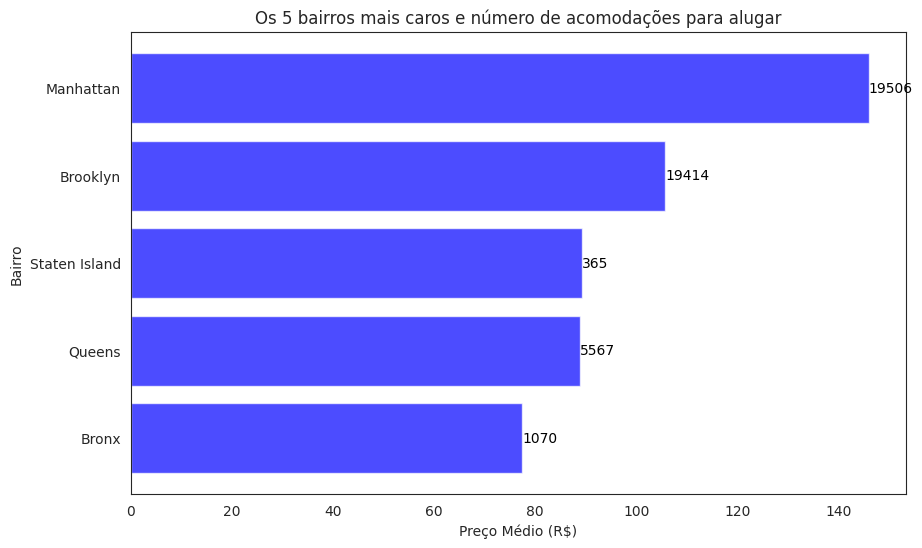

In [ ]:
preco_medio_por_bairro = df.groupby('neighborhood_group')['price'].mean().sort_values(ascending=False).head(5)

num_acomodacoes_por_bairro = df['neighborhood_group'].value_counts()

dados = pd.DataFrame({'Preço Médio': preco_medio_por_bairro, 'Número de Acomodações': num_acomodacoes_por_bairro})

dados = dados.dropna()

dados = dados.sort_values(by='Preço Médio', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(dados.index, dados['Preço Médio'], color='blue', alpha=0.7)

for bar, num_acomodacoes in zip(bars, dados['Número de Acomodações']):
    if pd.notna(num_acomodacoes):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, num_acomodacoes,
                va='center', ha='left', color='black', fontsize=10)

plt.title('Os 5 bairros mais caros e número de acomodações para alugar')
plt.xlabel('Preço Médio (R$)')
plt.ylabel('Bairro')

plt.show()

É perceptível que o bairro com mais acomodações para locação é Manhattan, com 19506 acomodações e o valor médio acima de 140 dólares. Em seguida, vem Brooklyn com 19414 acomodações e o valor médio acima de 100 dólares. Staten Island tem 365 acomodações com valor médio acima de 80 dólares, Queens tem 5567 acomodações também com valor médio acima de 80 dólares, e Bronx tem 1070 acomodações com valor médio acima de 70 dólares.

### Como os preços variam ao longo do tempo?

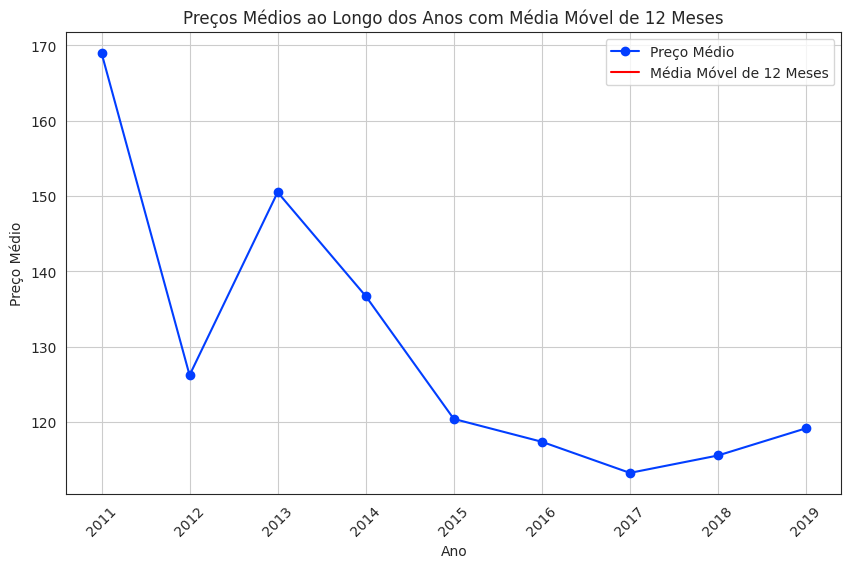

In [ ]:

df_analise = df
df_analise['last_review'] = pd.to_datetime(df_analise['last_review'])
df_analise['ano'] = df_analise['last_review'].dt.year  # pega o ano dos reviews para ter uma analise

preco_medio_por_ano = df.groupby('ano')['price'].mean()

preco_medio_12_meses = preco_medio_por_ano.rolling(window=12).mean()

plt.figure(figsize=(10, 6))
plt.plot(preco_medio_por_ano.index, preco_medio_por_ano, marker='o', linestyle='-', label='Preço Médio')
plt.plot(preco_medio_12_meses.index, preco_medio_12_meses, color='red', label='Média Móvel de 12 Meses')
plt.title('Preços Médios ao Longo dos Anos com Média Móvel de 12 Meses')
plt.xlabel('Ano')
plt.ylabel('Preço Médio')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

Note-se que de 2011 para 2012 ocorreu uma queda abrupta no preço médio de locação, uma queda de mais de 40 dólares. Em 2012, houve uma melhora, com um aumento de cerca de 30 dólares. No entanto, nos anos seguintes, o preço caiu drasticamente novamente, atingindo o menor valor médio entre 2011 e 2019 em 2017, com médias abaixo de 120 dólares. Após 2017, houve uma melhora, mas bem gradual.

### Qual é a média de noites por tipo de acomodação?

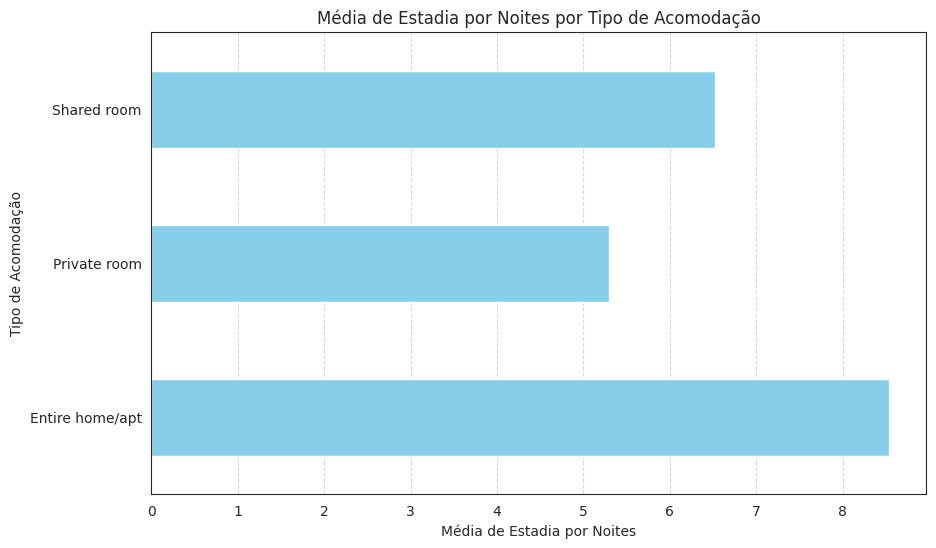

In [ ]:
media_estadia_por_tipo = df.groupby('room_type')['minimum_nights'].mean()

#  barras
plt.figure(figsize=(10, 6))
media_estadia_por_tipo.plot(kind='barh', color='skyblue')

plt.title('Média de Estadia por Noites por Tipo de Acomodação')
plt.xlabel('Média de Estadia por Noites')
plt.ylabel('Tipo de Acomodação')

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Pode-se perceber que a média do tempo mínimo de noites por estadia é mais alta em "Entire Home/Apt", seguido por "Shared Room".

### Qual foi a evolução da procura por diferentes tipos de acomodação ao longo dos anos?



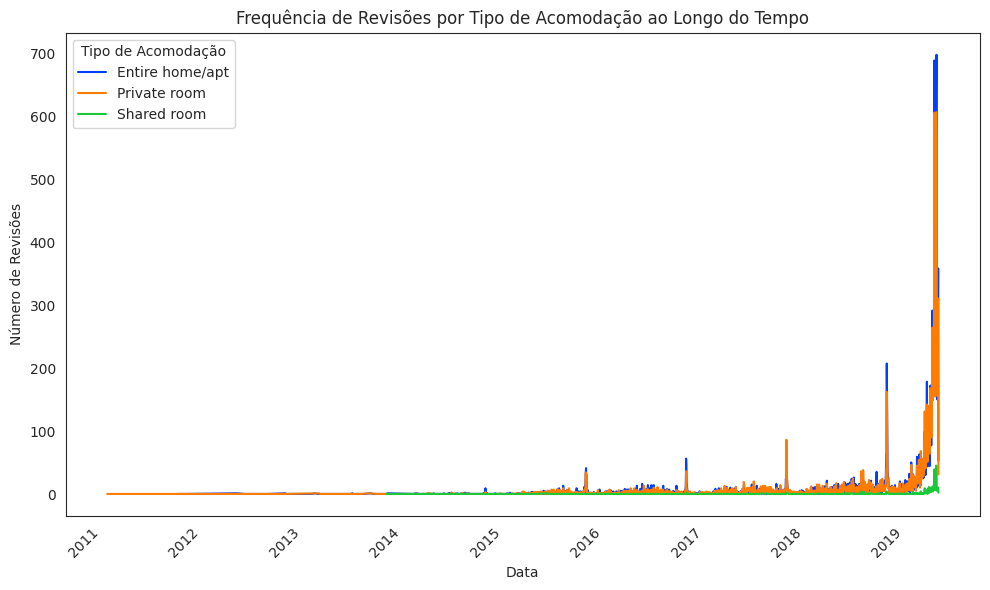

In [ ]:
df['last_review'] = pd.to_datetime(df['last_review'])

plt.figure(figsize=(10, 6))

for tipo in df['room_type'].unique():
    tipo_df = df[df['room_type'] == tipo]
    revisoes_por_data = tipo_df.groupby('last_review').size()
    plt.plot(revisoes_por_data.index, revisoes_por_data, label=tipo)

plt.title('Frequência de Revisões por Tipo de Acomodação ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Número de Revisões')
plt.legend(title='Tipo de Acomodação')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Analisando o número de avaliações feitas para cada tipo de acomodação ao longo dos anos, é perceptível que houve uma procura notável por quartos compartilhados entre 2014 e 2015. No entanto, ao longo dos anos, a locação de quartos privados sempre foi predominante. No último ano de coleta de dados, a locação de casas e apartamentos foi maior.

## Como os pontos turísticos estão distribuídos em diferentes bairros da cidade?

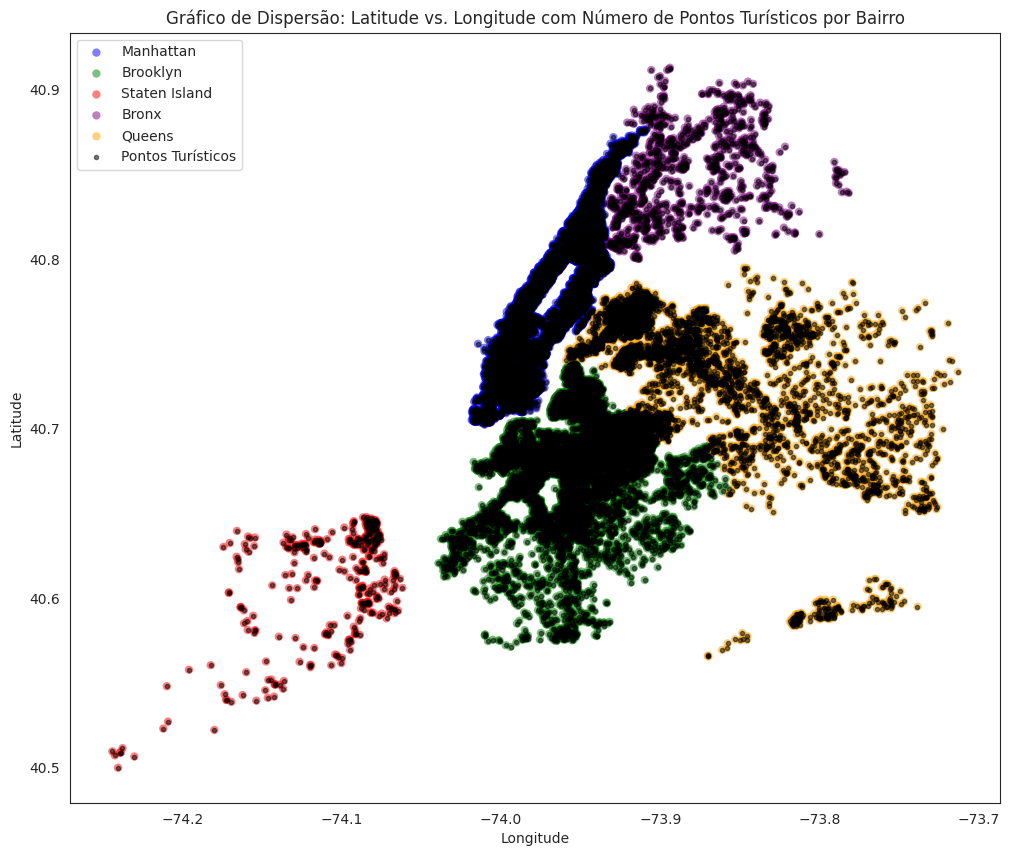

In [ ]:
data = df

manhattan = data[data['neighborhood_group'] == 'Manhattan']
brooklyn = data[data['neighborhood_group'] == 'Brooklyn']
staten_island = data[data['neighborhood_group'] == 'Staten Island']
bronx = data[data['neighborhood_group'] == 'Bronx']
queens = data[data['neighborhood_group'] == 'Queens']

plt.figure(figsize=(12, 10))

plt.scatter(manhattan['longitude'], manhattan['latitude'], c='blue', alpha=0.5, marker='o', label='Manhattan', edgecolors='none')
plt.scatter(brooklyn['longitude'], brooklyn['latitude'], c='green', alpha=0.5, marker='o', label='Brooklyn', edgecolors='none')
plt.scatter(staten_island['longitude'], staten_island['latitude'], c='red', alpha=0.5, marker='o', label='Staten Island', edgecolors='none')
plt.scatter(bronx['longitude'], bronx['latitude'], c='purple', alpha=0.5, marker='o', label='Bronx', edgecolors='none')
plt.scatter(queens['longitude'], queens['latitude'], c='orange', alpha=0.5, marker='o', label='Queens', edgecolors='none')

plt.scatter(data['longitude'], data['latitude'], c='black', alpha=0.5, marker='.', label='Pontos Turísticos')

plt.legend()

densest_neighborhood = data.loc[data['tourist_spot_count'].idxmax()]['neighborhood_group']

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Gráfico de Dispersão: Latitude vs. Longitude com Número de Pontos Turísticos por Bairro')

plt.show()


Neste mapa, foi utilizado o seguinte processamento: acessamos a base de dados de pontos turísticos, comparamos o total de pontos turísticos por bairro que está no mapa e fizemos a distribuição. Podemos analisar que o bairro que possui mais pontos turísticos é Manhattan, seguido por Brooklyn.



# Pergunta 2

Responda também às seguintes perguntas:



## 2 a
 Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?


In [ ]:
def filter_and_print_result(df, room_type):
    average_price_by_room_type = df.groupby('room_type')['price'].mean()

    ten_more_average_price_by_room_type = average_price_by_room_type + 5
    ten_less_average_price_by_room_type = average_price_by_room_type - 10

    average_availability_by_room_type = df.groupby('room_type')['availability_365'].mean()
    ten_more_average_availability_by_room_type = average_availability_by_room_type + 10
    ten_less_average_availability_by_room_type = average_availability_by_room_type - 5

    min_price = ten_less_average_price_by_room_type[room_type]
    max_price = ten_more_average_price_by_room_type[room_type]

    min_availability = ten_less_average_availability_by_room_type[room_type]
    max_availability = ten_more_average_availability_by_room_type[room_type]

    result = df.query(f"room_type == '{room_type}' and {min_price} <= price <= {max_price} and {min_availability} <= availability_365 <= {max_availability}")
    return result


df1 = filter_and_print_result(df, 'Entire home/apt')

df2 = filter_and_print_result(df, 'Private room')

df3 = filter_and_print_result(df, 'Shared room')

final_df = pd.concat([df1, df2, df3], ignore_index=True)

average_availability_by_room_type = final_df['availability_365'].mean()

acomodacoes_media = final_df.query(f" {(average_availability_by_room_type - 10 )} <= availability_365 <= {(average_availability_by_room_type + 10 )}")

contagem_por_bairro_group = acomodacoes_media.groupby('neighborhood_group').size()

print(contagem_por_bairro_group)

neighborhood_group
Bronx         2
Brooklyn     30
Manhattan    31
Queens        6
dtype: int64


Resposta A :
Após uma análise cuidadosa dos dados disponíveis, a escolha foi focar na região de Manhattan. Esta decisão foi baseada em uma série de fatores que foram considerados cruciais para garantir uma seleção precisa e adequada de acomodações para locação na plataforma.

Primeiramente, ao analisar os preços médios por tipo de acomodação em diferentes áreas, observou-se que os preços em Manhattan tendem a ser ligeiramente mais elevados em comparação com outras regiões. No entanto, essa disparidade nos preços é justificada pela localização privilegiada e pela demanda crescente por acomodações nessa área icônica de Nova York.

Além disso, ao calcular a média de disponibilidade ao longo do ano, percebeu-se que a disponibilidade média em Manhattan mantém-se em um nível bastante estável, o que é um indicativo positivo para investidores em busca de uma taxa de ocupação constante e uma renda regular proveniente do aluguel de suas propriedades.

Utilizando os critérios de filtragem estabelecidos, que levam em consideração não apenas o preço e a disponibilidade, mas também outros aspectos importantes, como o tipo de acomodação, foi possível identificar uma seleção de acomodações que atendem aos critérios estabelecidos.

Ao consolidar essas informações e analisar a distribuição das acomodações selecionadas por grupos de bairros em Manhattan, ficou evidente que essa região oferece uma ampla variedade de opções de acomodação, que podem atender a diversas necessidades e preferências dos potenciais locatários.

Portanto, com base na análise detalhada dos dados e considerando os fatores mencionados, a escolha estratégica foi focar na região de Manhattan como a área mais indicada para investir em acomodações para locação na plataforma, oferecendo uma combinação ideal de valor, localização e potencial de retorno do investimento.







## 2 b
 O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?




In [ ]:
correlacao_spearman = df[['minimum_nights', 'availability_365', 'price']].corr(method='spearman')

print("Matriz de Correlação de Spearman:")
print(correlacao_spearman)

Matriz de Correlação de Spearman:
                  minimum_nights  availability_365     price
minimum_nights          1.000000          0.073099  0.102678
availability_365        0.073099          1.000000  0.051157
price                   0.102678          0.051157  1.000000


Através da análise de correlação de Spearman, que é particularmente útil para avaliar relações não lineares entre variáveis, verificamos que não existe uma relação direta entre o número mínimo de noites, a disponibilidade ao longo do ano e o preço da acomodação. Isso sugere que essas variáveis não têm uma influência significativa no preço.

Abaixo, apresentamos a matriz de correlação de Spearman, onde os valores de correlação entre as variáveis estão indicados:

```
                     minimum_nights  availability_365     price
minimum_nights            1.000000             0.073099  0.102651
availability_365          0.073099             1.000000  0.051153
price                     0.102651             0.051153  1.000000

```

Os valores próximos a zero denotam uma correlação fraca entre as variáveis em análise.

Além disso, a análise exploratória revelou que os tipos de acomodação com maior tempo mínimo de estadia foram "Entire Home" e "Shared Room", que possuem médias de preços distintas. Isso reforça a ideia de que o tempo mínimo de estadia não influencia diretamente o valor do aluguel.


## 2 c
 Existe algum padrão no texto do nome do local para lugares de mais alto valor?

In [ ]:
p90 = df['price'].quantile(0.90)

locais_mais_caros = df[df['price'] > p90]


In [ ]:


import nltk
nltk.download('punkt')
nltk.download('stopwords')

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

serie_name = locais_mais_caros['name'].str.lower().apply(remove_special_characters)

stop_words = set(nltk.corpus.stopwords.words('english'))

def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    tokens_sem_stopwords = [palavra for palavra in tokens if palavra.lower() not in stop_words]
    texto_sem_stopwords = ' '.join(tokens_sem_stopwords)
    return texto_sem_stopwords

serie_sem_stopwords = serie_name.apply(remove_stopwords)

tokens = [nltk.word_tokenize(texto) for texto in serie_sem_stopwords.tolist()]

finder = BigramCollocationFinder.from_documents(tokens)

min_ocorrencias = (len(serie_name) * 0.03)

bigramas_frequentes = finder.ngram_fd.items()
bigramas_frequentes = [bigrama for bigrama, ocorrencias in bigramas_frequentes if ocorrencias >= min_ocorrencias]

array_bigrama = []
print("Bigramas frequentes:")
for bigrama in bigramas_frequentes:
    array_bigrama.append(bigrama)

print(array_bigrama)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Bigramas frequentes:
[('2', 'bedroom'), ('east', 'village'), ('central', 'park'), ('1', 'bedroom'), ('west', 'village')]


Após realizar uma análise dos preços mais altos de acomodação (top 10%), foi identificado que os nomes comuns entre essas propriedades incluem "2 quartos", "East Village", "Central Park", "West Village" e "1 quarto".


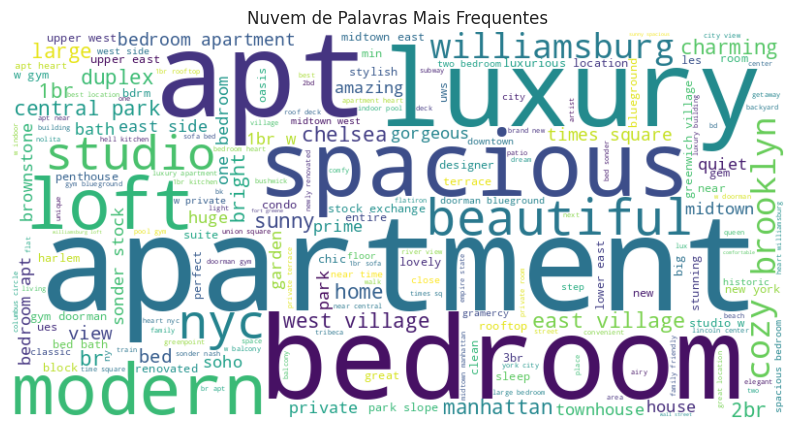

In [ ]:
texto = ' '.join(serie_sem_stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras Mais Frequentes')
plt.show()
